# Anomaly Detection Model for IoT Traffic

In [1]:
# imports
import pandas as pd
import seaborn as sns
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import xgboost as xgb

### Loading the dataset and replacing all blank values

In [2]:
# Load data into a pandas dataframe
data = pd.read_csv('UNSW_NB15_training-set.csv')

# Remove all NAN columns or replace with desired string
# This loop iterates over all of the column names which are all NaN
for column in data.columns[data.isna().any()].tolist():
    [column] = data[column].fillna('None')

# Feature Selection and Preprocessing

### Through the correlation heatmap we can discover which features are heavily correlated and eliminate them from the feature list

/var/folders/0c/n13fj4_50tbgf6_b03xj9dr00000gn/T/ipykernel_42618/4240241330.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5]),
 [Text(0.5, 0, 'id'),
  Text(1.5, 0, 'dur'),
  Text(2.5, 0, 'spkts'),
  Text(3.5, 0, 'dpkts'),
  Text(4.5, 0, 'sbytes'),
  Text(5.5, 0, 'dbytes'),
  Text(6.5, 0, 'rate'),
  Text(7.5, 0, 'sttl'),
  Text(8.5, 0, 'dttl'),
  Text(9.5, 0, 'sload'),
  Text(10.5, 0, 'dload'),
  Text(11.5, 0, 'sloss'),
  Text(12.5, 0, 'dloss'),
  Text(13.5, 0, 'sinpkt'),
  Text(14.5, 0, 'dinpkt'),
  Text(15.5, 0, 'sjit'),
  Text(16.5, 0, 'djit'),
  Text(17.5, 0, 'swin'),
  Text(18.5, 0, 'stcpb'),
  Text(19.5, 0, 'dtcpb'),
  Text(20.5, 0, 'dwin'),
  Text(21.5, 0, 'tcprtt'),
  Text(22.5, 0, 'synack'),
  Text(23.5, 0, 'ackdat'),
  Text(24.5, 0, 'smean'),
  Text(25.5, 0, 'dmean'),
  Text(26.5, 0, 'trans_depth'),
  Text(27.5, 0, 'response_b

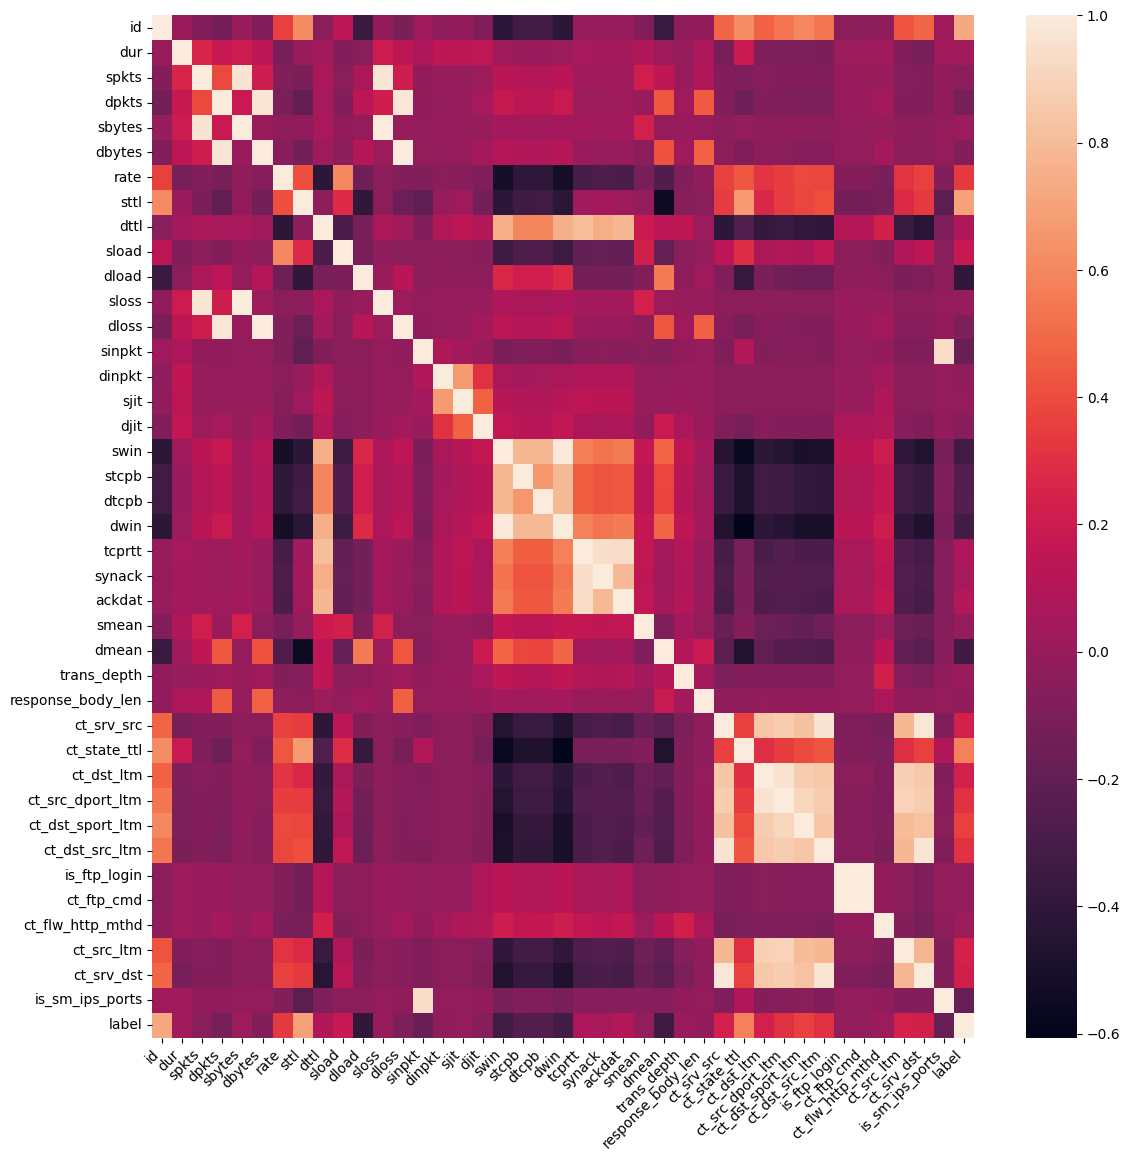

In [3]:
# Calculate correlation matrix
corr_matrix = data.corr()

# Create a heatmap using seaborn
# sns.heatmap(corr_matrix, annot=False)
plt.figure(figsize=(12,12))
sns.heatmap(corr_matrix, annot=False, yticklabels=corr_matrix.columns)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')

#### All features must be numerical values so we encode them using a Label Encoder
#### Then we remove the heavily correclated features

In [4]:
# Apply LabelEncoder to the entire dataframe
le = LabelEncoder()
data = data.apply(le.fit_transform)

# Remove some columns that may be needed for the model
data = data.drop(['is_sm_ips_ports', 'ct_srv_dst', 'ct_ftp_cmd', 
                'ct_dst_src_ltm', 'ct_srv_src', 'dwin', 'swin', 
                'sinpkt', 'dloss', 'sloss', 'sbytes', 'dbytes',
                'spkts', 'dpkts'], axis=1)

## Using an autoencoder as a preproccesor to create the final features that will be sent to our model

In [5]:
# Load and preprocess your data
# X is your input data, y is your target labels
X = data.drop(['label', 'attack_cat'], axis=1).values
y = data['label']
# Normalize the datas
X = X / 255.

# Reshape the data if necessary
X = X.reshape((len(X), np.prod(X.shape[1:])))

X = X[:175341]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set the encoding dimensions
hidden_dim1 = 32
hidden_dim2 = 16
hidden_dim3 = 8


# Define the input layer
input_img = Input(shape=(29,))

# Define the encoder layers
hidden_layer_1 = Dense(hidden_dim1, activation='relu')(input_img)
hidden_layer_2 = Dense(hidden_dim2, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(hidden_dim3, activation='relu')(hidden_layer_2)


# Define the decoder layers
decoder_hidden_1 = Dense(hidden_dim2, activation='relu')(hidden_layer_3)
decoder_hidden_2 = Dense(hidden_dim1, activation='relu')(hidden_layer_2)
decoder_output = Dense(29, activation='relu')(hidden_layer_1)

# Define the autoencoder model
autoencoder = Model(input_img, decoder_output)

# Get the encoder model
encoder = Model(input_img, hidden_layer_1)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True)

# Use the encoder to extract features from the data
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

Epoch 1/50


2023-02-25 20:41:12.007876: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


548/548 [==============================] - 1s 415us/step - loss: 1559.3685
Epoch 2/50
548/548 [==============================] - 0s 396us/step - loss: 108.8816
Epoch 3/50
548/548 [==============================] - 0s 438us/step - loss: 89.7331
Epoch 4/50
548/548 [==============================] - 0s 388us/step - loss: 84.1370
Epoch 5/50
548/548 [==============================] - 0s 386us/step - loss: 82.4492
Epoch 6/50
548/548 [==============================] - 0s 385us/step - loss: 82.0143
Epoch 7/50
548/548 [==============================] - 0s 386us/step - loss: 81.8577
Epoch 8/50
548/548 [==============================] - 0s 385us/step - loss: 81.7708
Epoch 9/50
548/548 [==============================] - 0s 386us/step - loss: 81.7121
Epoch 10/50
548/548 [==============================] - 0s 390us/step - loss: 81.6683
Epoch 11/50
548/548 [==============================] - 0s 387us/step - loss: 81.6346
Epoch 12/50
548/548 [==============================] - 0s 386us/step - loss: 81.61

              precision    recall  f1-score   support

           0    0.98475   0.93061   0.95691     11169
           1    0.96839   0.99326   0.98067     23900

    accuracy                        0.97331     35069
   macro avg    0.97657   0.96194   0.96879     35069
weighted avg    0.97360   0.97331   0.97310     35069



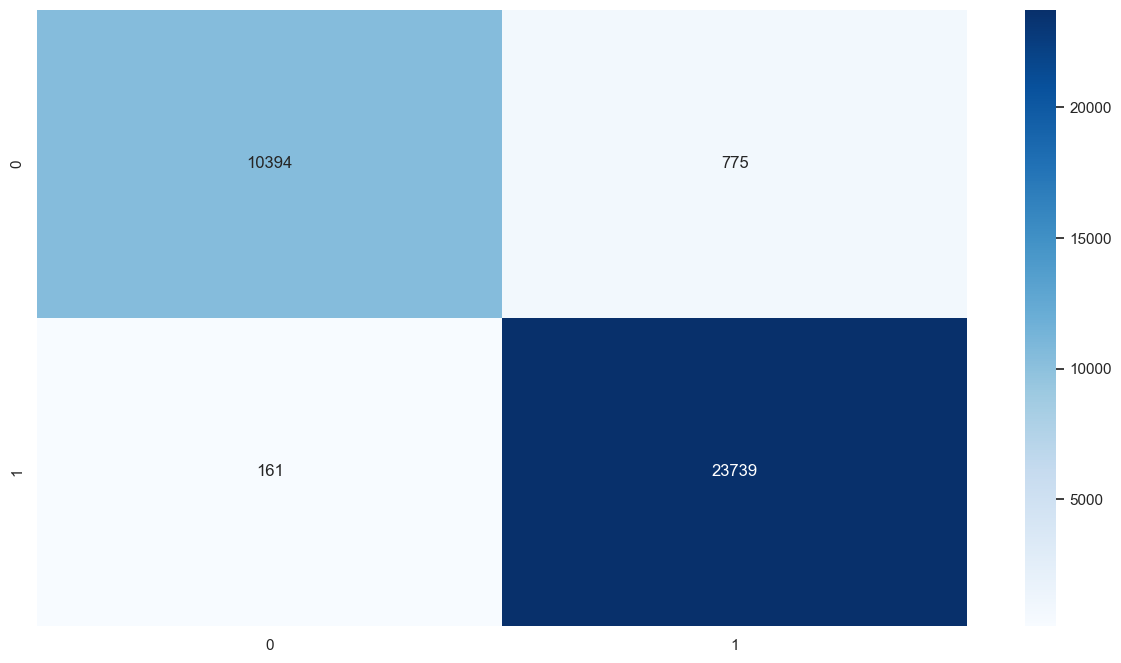

In [6]:
# Train a Random Forest classifier on the encoded features
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42)
knn_model = KNeighborsClassifier()

# Create the voting classifier
voting_clf = VotingClassifier(estimators=[('xgb', xgb_model), ('rf', rf_model), ('knn', knn_model)], voting='hard')
voting_clf.fit(X_train_encoded, y_train)

# Make predictions on the test data
y_pred = voting_clf.predict(X_test_encoded)

# We print our results
sns.set(rc={'figure.figsize':(15,8)})

predictions = voting_clf.predict(X_test_encoded)

true_labels = y_test
clf_matrix = confusion_matrix(true_labels, predictions)
clf_report = classification_report(true_labels, predictions, digits=5)
heatmap = sns.heatmap(clf_matrix, annot=True, cmap='Blues', fmt='g', 
                      xticklabels=np.unique(true_labels), 
                      yticklabels=np.unique(true_labels)) 

print(clf_report)

In [7]:
# Calculate the accuracy, recall, precision and f1-score of the classifier
acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(' Accuracy: ', acc)
print('Recall: ', rec)
print('Precision: ', prec)
print('f1-score: ', f1)

 Accuracy:  0.9733097607573641
Recall:  0.9932635983263598
Precision:  0.9683854124173942
f1-score:  0.9806667492873963


## Making GUI Using Gradio

In [ ]:
import gradio as gr

def detect(id, dur, proto, service, state, spkts, dpkts, sbytes, dbytes, rate, sttl, dttl, sload, dload, sloss, dloss, sinpkt, dinpkt, sjit, djit, swin, stcpb, dtcpb, dwin, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_srv_src, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, ct_dst_src_ltm, is_ftp_login, ct_ftp_cmd, ct_flw_http_mthd, ct_src_ltm, ct_srv_dst, is_sm_ips_ports):
    
    x = np.array([id, dur, proto, service, state, rate, sttl, dttl, sload, dload, dinpkt, sjit, djit, stcpb, dtcpb, tcprtt, synack, ackdat, smean, dmean, trans_depth, response_body_len, ct_state_ttl, ct_dst_ltm, ct_src_dport_ltm, ct_dst_sport_ltm, is_ftp_login, ct_flw_http_mthd, ct_src_ltm])
    
    x = le.fit_transform(x)
    x = x / 255.
    x = encoder.predict(x.reshape(1, -1))
    
    prediction = voting_clf.predict(x.reshape(1, -1))
    if prediction[0] == 0:
        return "Normal"
    else:
        return "Anomaly"

outputs = gr.outputs.Textbox()
inputs = ['number']*43
inputs[2] = 'text'
inputs[3] = 'text'
inputs[4] = 'text'
app = gr.Interface(fn=detect, inputs=inputs, outputs=outputs,description="This is a IoT Anommaly Detection Model")

app.launch(share=True, server_name="0.0.0.0", server_port=8080)

## How to run : 
#### 1. Open terminal at folder containing the Dockerfile. 
#### 2. Run the following commands

In [ ]:
!docker build -t iot_det .

In [ ]:
!docker run -t -d -p 8080:8080 iot_det

The server will be running at:
http://0.0.0.0:8080